## Results of point pollution surface oil spill scenarios at English Bay
Loss of Power by a Bulker as it leaves Vancouver Harbour, collides with another Bulk Carier at Anchorage, spilling 15 m<sup>-3</sup> of Bunker C. Scenario built on ROC report 0570, 2020 and ROC report 201, 2019. The spill occurs in English Bay.

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
affected_boxes = [72, 74, 75, 80]

In [3]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Define scenario and control files

In [4]:
hex_colour = '#2F61A4' # alt #8CB7D7
hatches = ['oo', '///', 'xx', '++']

In [5]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_6a*_10000_alkyls.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [6]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Control/highres-control-3y-2019-2022/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])


In [7]:
scenario_paths = sorted([p for p in scenario_root.glob('highres-2019-2022_6a*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

highres-2019-2022_6a_1_2019-07-16 low Fraser flow spring tide summer
highres-2019-2022_6a_2_2019-07-25 low Fraser flow neap tide summer
highres-2019-2022_6a_3_2020-07-21 high Fraser flow spring tide summer
highres-2019-2022_6a_4_2020-07-13 high Fraser flow neap tide summer


In [8]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [9]:
# start and end time of data display, after burn-in
start = 0
end = time.size-1

## Mapping spill extent

EB-1 BOX_ID
75    108500408
Name: AREA, dtype: int64
EB-2 BOX_ID
75    108500408
80    596141541
Name: AREA, dtype: int64
EB-4 BOX_ID
75    108500408
Name: AREA, dtype: int64
EB-3 BOX_ID
72     50254125
74    117769594
75    108500408
Name: AREA, dtype: int64


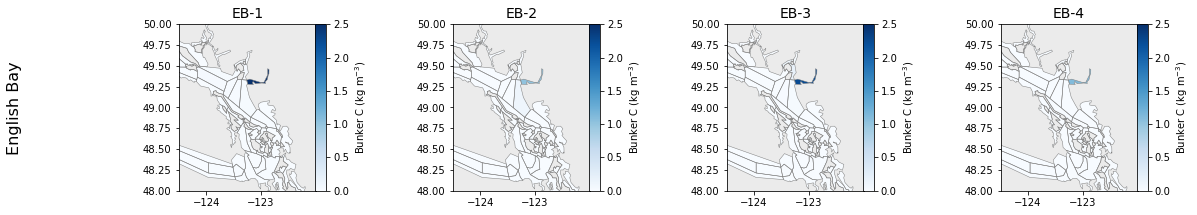

In [10]:
fig = plt.figure(figsize=(18, 6), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

for file, oil_path in zip(oil_files, oil_paths):
    date = str(oil_path).split(sep = '_')[3]
    label = 'EB-'+ str(groups.simulations[groups.conditions[date]])
    position = int(str(groups.simulations[groups.conditions[date]]))-1
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    oil_df = data_df.loc[data_df['oil'] > 0.1] #4% of max oil
    print(label,oil_df.AREA)


    ax = fig.add_subplot(gs[0, position], facecolor = '#EBEBEB')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5)
    ax = data_df.plot(column = 'oil', ax=ax, cax=cax,cmap=cm.Blues, legend_kwds={'label': 'Bunker C (kg m$^{-3}$)'}, vmax=2.5,
    #ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues, legend_kwds={'label': 'depth (m)'},
    legend=True, 
    )
    ax.set_title(label, fontsize = 14) #loc='left'
    ax.set_xlim(-124.5)
    ax.set_ylim(48, 50)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.5)
    land_df.plot(ax=ax, color='#EBEBEB')
    #oil_df.plot(ax=ax, color='red',linewidths=0.5)
fig.supylabel('English Bay', fontsize = 16); #color=hex_colour
fig.savefig("Figures/spill-map-EB.png", dpi=300, bbox_inches='tight')

### Oil Injection

In [11]:
def plot_pah(pah, start, end, scenario_datasets=scenario_datasets, scenario_paths=scenario_paths):
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
      (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets,scenario_paths):
        nm = path.parent.stem
        names.append(nm)
        contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
        contam_tb = contam_tbl.sum(axis=2)
        contam_t = contam_tb.sum(axis=1)
        ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
    ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
    ax.set_ylabel('mg PAH/m$^3$')
    ax.legend(names, loc='best');

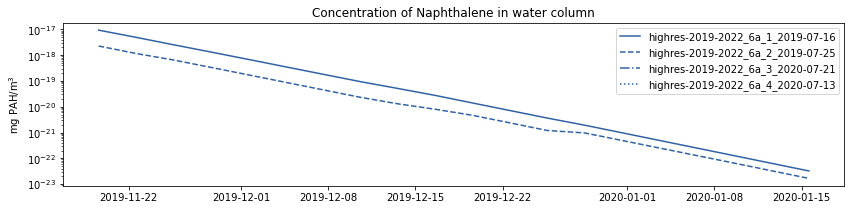

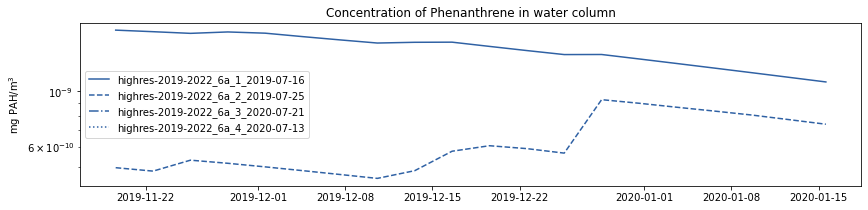

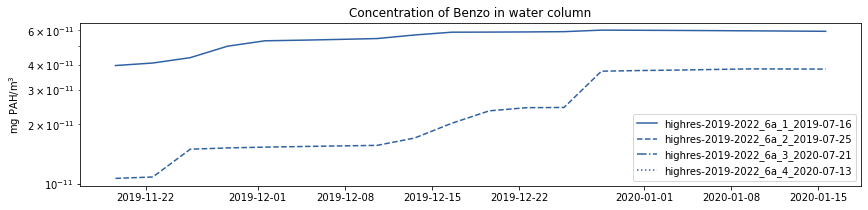

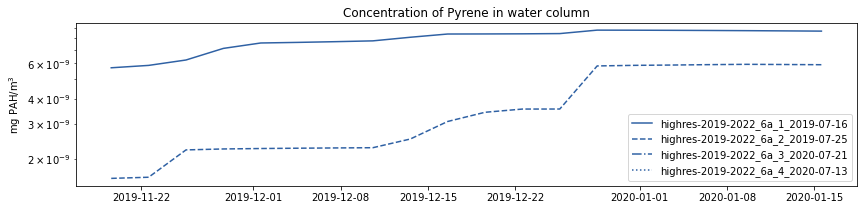

In [12]:
for pah in groups.pahs:
  plot_pah(pah, 110, 130)

## Results
### Time-separate box plot

In [13]:
def plot_benthic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k')
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

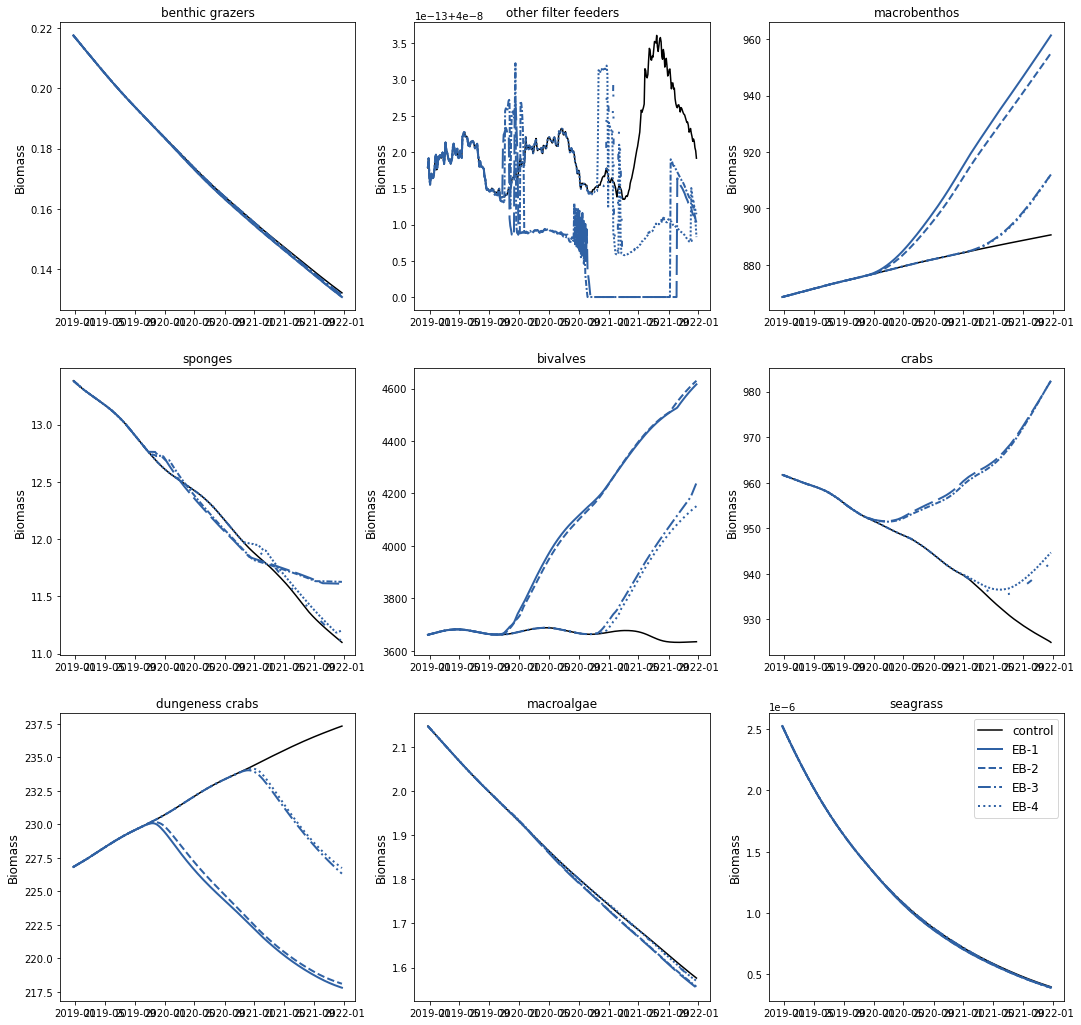

In [14]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths, boxes=affected_boxes)

In [15]:
def plot_aggregate_N(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    names = ['control']
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t, control_ratio, 'k', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'EB-'+nm[2]  

        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t, ratio, linewidth = 2, label=scenario_name, color=hex_colour, linestyle=next(line_styles))
    ax.fill_between(scenario.t, -groups.sensitivity[new_name], groups.sensitivity[new_name], color='grey', alpha=0.3, label='Model threshold')
        
    ax.set_ylabel('Percent (%) change', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1))

In [16]:
def plot_pelagic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t[start:end], control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t[start:end], ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t[start:end], -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [17]:
def plot_groups_benthic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [18]:
def plot_aggregate_biomass(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    ax.plot(control.t, pelagic_control, 'k--', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'EB-'+nm[2]  
        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ax.plot(scenario.t, pelagic_oiled, label=scenario_name, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
    ax.set_ylabel('Biomass', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(fontsize=12); #bbox_to_anchor=(1.05, 1)

In [19]:
def plot_benthic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k')
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'EB-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

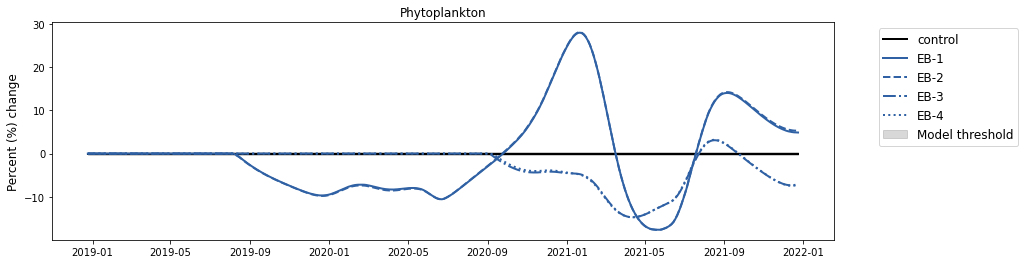

In [20]:
plot_aggregate_N(groups.phytoplankton,'Phytoplankton',scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

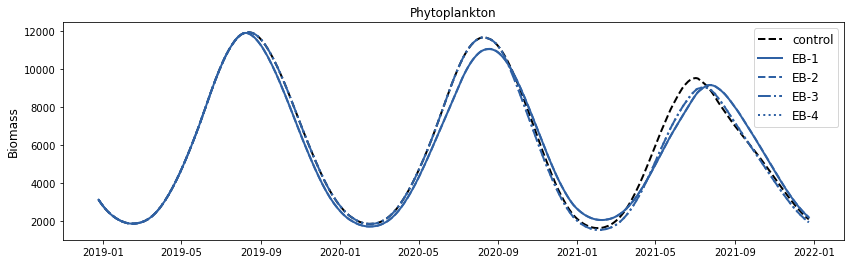

In [21]:
plot_aggregate_biomass(groups.phytoplankton,'Phytoplankton',scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

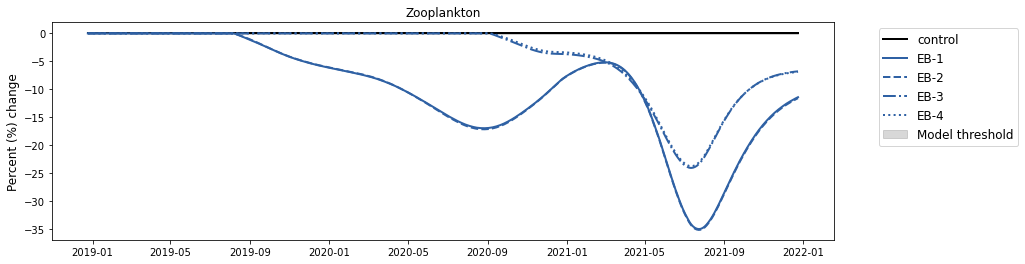

In [22]:
plot_aggregate_N(groups.zooplankton,'Zooplankton',scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

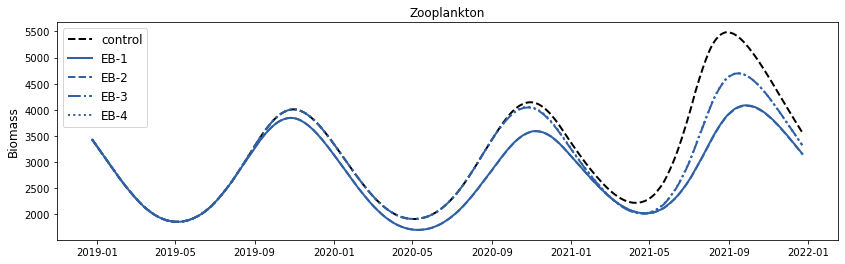

In [23]:
plot_aggregate_biomass(groups.zooplankton,'Zooplankton',scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

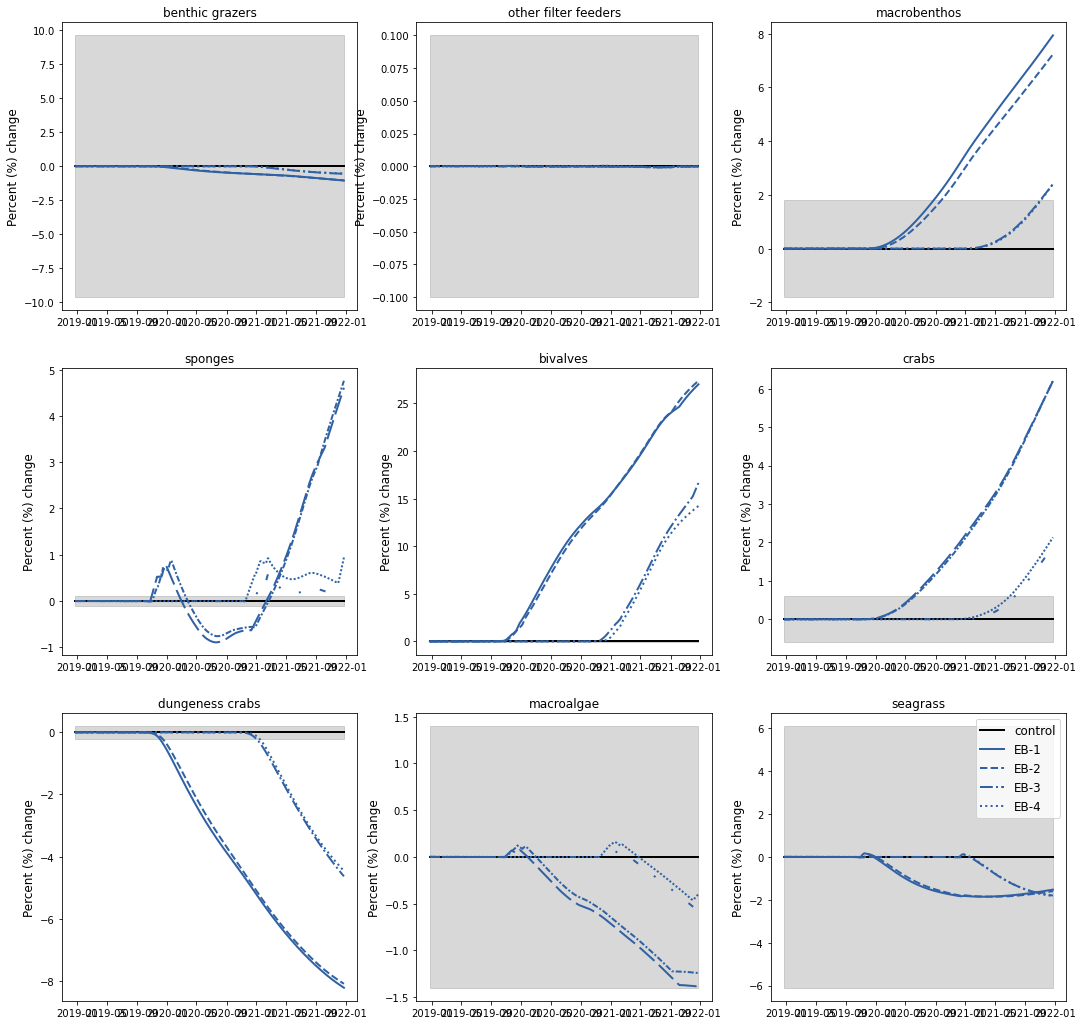

In [24]:
plot_groups_benthic_N(groups.benthos, scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

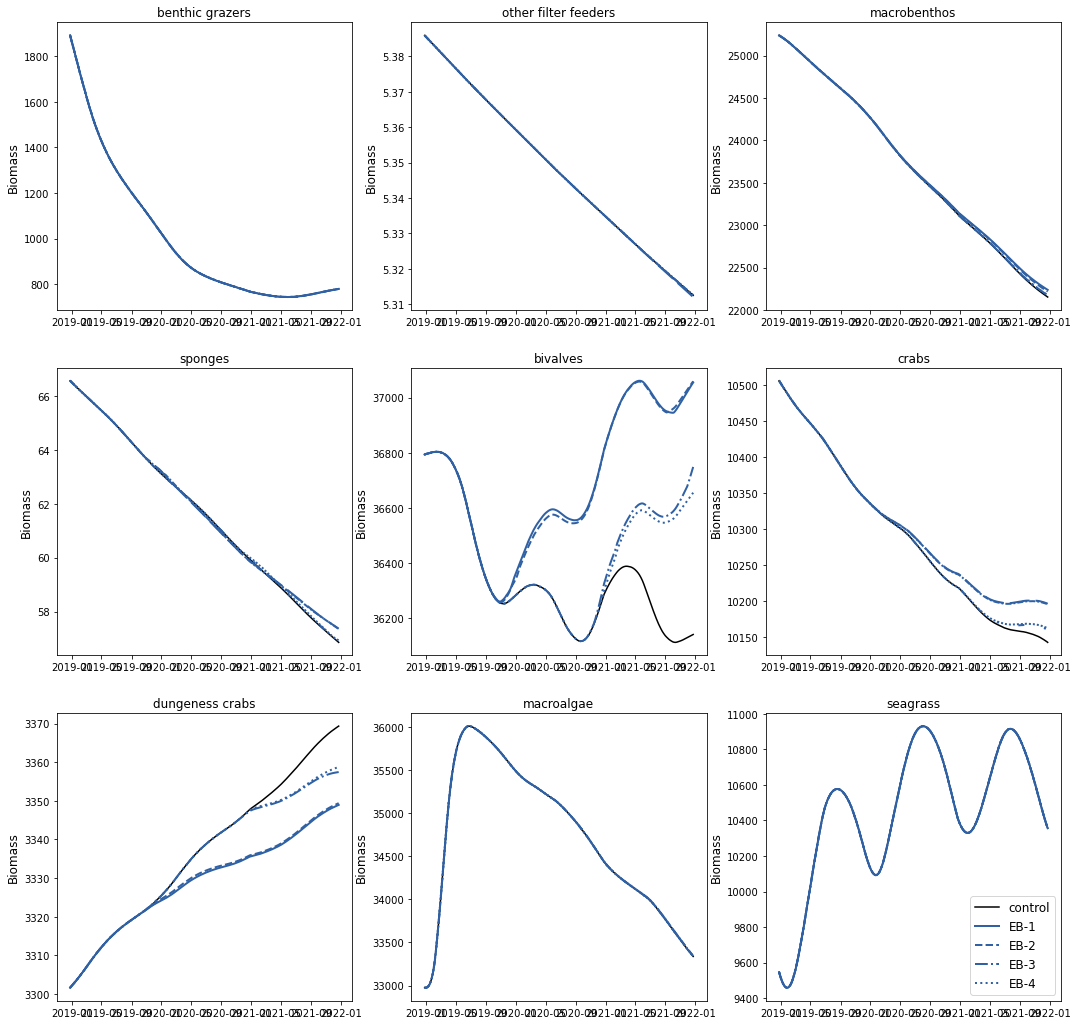

In [26]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths)